# Economics Problem Set 1




## Question 1


### 1. State variables:

Stock of oil $S_t$
Price $p_t$

### 2. Control variables:

Amount of oil to sell $x_t$

### 3. Transition equation:

$$S_{t+1} = S_t - x_t$$

### 4. Sequence problem

Max $E_{t}\{\Sigma_{s=1}^{\infty}p_{t+s}x_{t+s}(\frac{1}{1+r})^s) \}$
subject to $S_{t+s+1} = S_{t+s} - x_{t+s}$    $\forall s$ and $S_t = B$ and $S_{t+s} \geqslant 0$

The Bellman equation is of the form:

$$V(S) = Max_x\{px + \frac{1}{1+r} V(S - x)\}$$

### 5. The Euler equation

$$p_{t+s} = p_{t+1+s}(\frac{1}{1+r})$$

### 6. The solution

Since the payoff function is linear, the solution is piecewise.

If $p_{t+1+s} = p_{t+s}$ for all s, then $x_t = B$, i.e. we sell everything today. This is because we get the same absolute payoff from selling a marginal unit in any period, but we discount the future, so we sell everything today.

If $p_{t+1+s} > (1+r)p_{t+s}$ then $x_{t+s} = 0$ for all s. This is actually a violation of the transversality condition, and so the model is not stationary in this case.

A necessary condition for an interior solution is $p_{t+s}(1+r) = p_{t+s+1}$


## Question two:

### 1. State variables:

Capital today: $k_t$ 

Shock today: $z_t$

### 2. Control variables:

Consumption today: $c_t$

### 3. Bellman Equation:

$$V(z_t, k_t) = Max_c\{U(c_{t}) + \beta E_tV(z_{t+1}, k_{t+1})\}$$ \begin{align*} s.t.
\end{align*}

$$k_{t+1} + c_{t} = z_{t}k_{t}^\alpha + (1-\delta)k_{t}$$



#### Import some packages

In [2]:
#Imports
import numpy as np
import matplotlib.pyplot as plt

# to print plots inline
%matplotlib inline

### Set Parameters

Parameters:
* $\gamma$ : Coefficient of Relative Risk Aversion
* $\beta$ : Discount factor
* $\delta$ : Rate of depreciation
* $\alpha$ : Curvature of production function
* $\sigma_z$ : Standard dev of productivity shocks


In [3]:
gamma = 0.5
beta = 0.96
delta = 0.05
alpha = 0.4
sigmaz = 0.2

### Create Grid Space

In [38]:
'''
------------------------------------------------------------------------
Create Grid for State Space - Capital    
------------------------------------------------------------------------
lb_k      = scalar, lower bound of capital grid
ub_k      = scalar, upper bound of capital grid 
size_k    = integer, number of grid points in capital state space
k_grid    = vector, size_k x 1 vector of capital grid points 
------------------------------------------------------------------------
'''
lb_k = 10 #Note that the steady state of k is 11.65 so we create grid around that
ub_k = 13 

size_k = 30  # Number of grid points
k_grid = np.linspace(lb_k, ub_k, size_k)

'''
------------------------------------------------------------------------
Create Grid for State Space - Shock   
------------------------------------------------------------------------
lb_z      = scalar, lower bound of shock grid
ub_z      = scalar, upper bound of shock grid 
size_z    = integer, number of grid points in shock state space
z_grid    = vector, size_z x 1 vector of shock grid points 
------------------------------------------------------------------------
'''

'''
Create grid of taste shocks
'''
lb_z = 0.1 #Note that since logz is normally distributed, z cannot be below 0
ub_z = 10
size_z = 30  # Number of grid points
mu_z = 0
rho_z = 0
sigma_z = 0.2

import ar1_approx as ar1
ln_z_grid, pi = ar1.addacooper(size_z, mu_z, rho_z, sigma_z)
z_grid = np.exp(ln_z_grid)
pi_z = np.transpose(pi)

'''
------------------------------------------------------------------------
Create grid of current utility values    
------------------------------------------------------------------------
C        = matrix, current consumption (c=z_tk_t^a - k_t+1 + (1-delta)k_t)
U        = matrix, current period utility value for all possible
           choices of w and w' (rows are w, columns w')
------------------------------------------------------------------------
'''

C = np.zeros((size_k, size_k, size_z)) 
for i in range(size_k): # loop over w
    for j in range(size_k): # loop over w'
        for q in range(size_z):
            C[i, j, q] = z_grid[q] * k_grid[i] **alpha + (1 - delta)*k_grid[i] - k_grid[j]
            # note that if w'>w, consumption negative
# replace 0 and negative consumption with a tiny value 
# This is a way to impose non-negativity on cons

#Not sure if it's good
C[C<=0] = 1e-15
if gamma == 1:
    U = np.log(C)
else:
    U = (C ** (1 - gamma)) / (1 - gamma)
U[C<0] = -9999999

**Next Part:**

In [39]:
'''
------------------------------------------------------------------------
Value Function Iteration    
------------------------------------------------------------------------
VFtol       = scalar, tolerance required for value function to converge
VFdist      = scalar, distance between last two value functions
VFmaxiter   = integer, maximum number of iterations for value function
V           = matrix, the value functions at each iteration
TV          = matrix, the value function after applying the Bellman operator
PF_discrete = matrix, matrix of policy function: eat=1, not eat=0 
Vstore      = array, stores V at each iteration 
VFiter      = integer, current iteration number
EV          = scalar, expected value function for a given state
U_eat       = matrix, utility from eating cake now
Vwait       = matrix, value of waiting to eat the cake
VF          = vector, the "true" value function
------------------------------------------------------------------------
'''
VFtol = 1e-6
VFdist = 7.0 
VFmaxiter = 500 
V = np.zeros((size_k, size_z)) # initial guess at value function
Vmat = np.zeros((size_k, size_k, size_z))
Vstore = np.zeros((size_k, size_k, VFmaxiter)) #initialize Vstore array
VFiter = 1 
while VFdist > VFtol and VFiter < VFmaxiter:
    print("This is the distance:", VFdist, VFiter)
    for i in range(size_k): # loop over epsilon
        for j in range(size_k): # loop over w
            for k in range(size_z):
                EV = 0
                for ii in range(size_z):
                    EV += pi_z[k, ii]*V[j, ii]
                Vmat[i, j, k] = U[i, j, k] + beta * EV
    Vstore[:, :, VFiter] = V.reshape(size_k, size_z,) # store value function at each iteration for graphing later 
    TV = Vmat.max(1)
    PF = np.argmax(Vmat, axis=1)
    VFdist = (np.absolute(V - TV)).max()  # check distance
    V = TV
    VFiter += 1 

if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')            


VF = V # solution to the functional equation

This is the distance: 7.0 1
This is the distance: 5.17888220414344 2
This is the distance: 3.069633819203789 3
This is the distance: 2.7909705824881925 4
This is the distance: 2.6159159613838856 5
This is the distance: 2.481742027140589 6
This is the distance: 2.369272997422602 7
This is the distance: 2.2675005029698774 8
This is the distance: 2.172699182216725 9
This is the distance: 2.083202028432268 10
This is the distance: 1.99816711813655 11
This is the distance: 1.917064288953604 12
This is the distance: 1.83954399353658 13
This is the distance: 1.765370253223832 14
This is the distance: 1.6943195871121617 15
This is the distance: 1.6262156910986718 16
This is the distance: 1.560921863292151 17
This is the distance: 1.4983027475879283 18
This is the distance: 1.4382306462523076 19
This is the distance: 1.3805933865853746 20
This is the distance: 1.3252863724685184 21
This is the distance: 1.2722099022089992 22
This is the distance: 1.2212708037955622 23
This is the distance: 1.17

This is the distance: 0.001778804916284571 183
This is the distance: 0.0017076527196309144 184
This is the distance: 0.0016393466108439725 185
This is the distance: 0.0015737727464113505 186
This is the distance: 0.00151082183657536 187
This is the distance: 0.0014503889631072298 188
This is the distance: 0.001392373404570435 189
This is the distance: 0.001336678468405239 190
This is the distance: 0.0012832113296639136 191
This is the distance: 0.0012318828764676937 192
This is the distance: 0.0011826075614180809 193
This is the distance: 0.0011353032589624945 194
This is the distance: 0.0010898911286290058 195
This is the distance: 0.001046295483462245 196
This is the distance: 0.0010044436641436505 197
This is the distance: 0.0009642659175739254 198
This is the distance: 0.0009256952808556207 199
This is the distance: 0.0008886674696384489 200
This is the distance: 0.0008531207708415423 201
This is the distance: 0.0008189959400226599 202
This is the distance: 0.0007862361024137954 20

This is the distance: 1.7228122146661917e-06 353
This is the distance: 1.653899744269438e-06 354
This is the distance: 1.5877437817835016e-06 355
This is the distance: 1.524234022554083e-06 356
This is the distance: 1.4632646525569726e-06 357
This is the distance: 1.4047340926026664e-06 358
This is the distance: 1.348544699908416e-06 359
This is the distance: 1.2946029244176316e-06 360
This is the distance: 1.2428188114199656e-06 361
This is the distance: 1.1931060726055875e-06 362
This is the distance: 1.1453818018480888e-06 363
This is the distance: 1.0995665462587567e-06 364
This is the distance: 1.055583879860933e-06 365
This is the distance: 1.0133605314877059e-06 366
Value function converged after this many iterations: 367


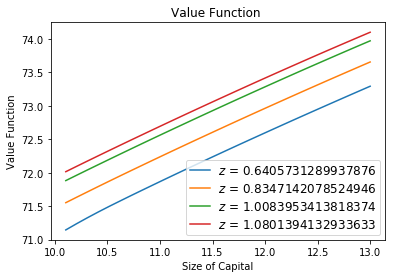

In [40]:
# Plot value function 
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[1:], VF[1:, 0], label='$z$ = ' + str(z_grid[0]))
ax.plot(k_grid[1:], VF[1:, 5], label='$z$ = ' + str(z_grid[5]))
ax.plot(k_grid[1:], VF[1:, 15], label='$z$ = ' + str(z_grid[15]))
ax.plot(k_grid[1:], VF[1:, 19], label='$z$ = ' + str(z_grid[19]))
# Now add the legend with some customizations.
legend = ax.legend(loc='lower right', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital')
plt.ylabel('Value Function')
plt.title('Value Function ')
plt.show()

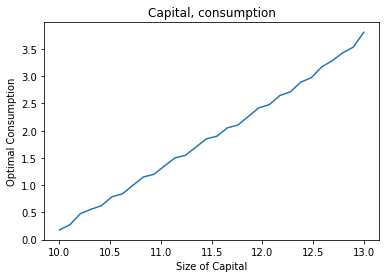

In [41]:
#Plot optimal consumption rule
optK = k_grid[PF]
optC = z_grid * k_grid ** (alpha) + (1 - delta) * k_grid - optK
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[:], optC[:][17], label='Consumption')
# Now add the legend with some customizations.
#legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital')
plt.ylabel('Optimal Consumption')
plt.title('Capital, consumption')
plt.show()

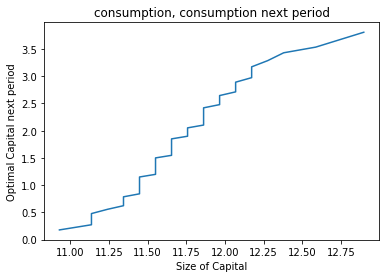

In [42]:
#Plot optimal capital next period
optK = k_grid[PF]
plt.figure()
fig, ax = plt.subplots()
ax.plot(optK[:][17], optC[:][17], label='Consumption')
# Now add the legend with some customizations.
#legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital')
plt.ylabel('Optimal Capital next period')
plt.title('consumption, consumption next period')
plt.show()

## Problem 3:

### 1. Bellman Equation:

$$V(z_t, k_t) = Max_c\{U(c_{t}) + \beta E_{z_{t+1} | z_t} V(z_{t+1}, k_{t+1})\}$$ \begin{align*} s.t.
\end{align*}

$$k_{t+1} + c_{t} = z_{t}k_{t}^\alpha + (1-\delta)k_{t}$$


### Set Parameters

Parameters:
* $\gamma$ : Coefficient of Relative Risk Aversion
* $\beta$ : Discount factor
* $\delta$ : Rate of depreciation
* $\alpha$ : Curvature of production function
* $\sigma_z$ : Standard dev of productivity shocks

In [9]:
#Parameters
gamma = 0.5
beta = 0.96
delta = 0.05
alpha = 0.4
sigmaz = 0.2

In [10]:
#Create Grid Space
'''
------------------------------------------------------------------------
Create Grid for State Space - Capital    
------------------------------------------------------------------------
lb_k      = scalar, lower bound of capital grid
ub_k      = scalar, upper bound of capital grid 
size_k    = integer, number of grid points in capital state space
k_grid    = vector, size_k x 1 vector of capital grid points 
------------------------------------------------------------------------
'''
lb_k = 10 #Note that the steady state of k is 11.65 so we create grid around that
ub_k = 13 

size_k = 30  # Number of grid points
k_grid = np.linspace(lb_k, ub_k, size_k)

'''
------------------------------------------------------------------------
Create Grid for State Space - Shock   
------------------------------------------------------------------------
lb_z      = scalar, lower bound of shock grid
ub_z      = scalar, upper bound of shock grid 
size_z    = integer, number of grid points in shock state space
z_grid    = vector, size_z x 1 vector of shock grid points 
------------------------------------------------------------------------
'''

'''
Create grid of taste shocks
'''
lb_z = 0.1 #Note that since logz is normally distributed, z cannot be below 0
ub_z = 10
size_z = 30  # Number of grid points
mu_z = 0
rho_z = 0.8
sigma_v = 0.1

import ar1_approx as ar1
ln_z_grid, pi = ar1.addacooper(size_z, mu_z, rho_z, sigma_v)
z_grid = np.exp(ln_z_grid)
pi_z = np.transpose(pi)

'''
------------------------------------------------------------------------
Create grid of current utility values    
------------------------------------------------------------------------
C        = matrix, current consumption 
U        = matrix, current period utility value 
------------------------------------------------------------------------
'''

C = np.zeros((size_k, size_k, size_z)) 
for i in range(size_k): # loop over w
    for j in range(size_k): # loop over w'
        for q in range(size_z):
            C[i, j, q] = z_grid[q] * k_grid[i] **alpha + (1 - delta)*k_grid[i] - k_grid[j]
            # note that if w'>w, consumption negative
# replace 0 and negative consumption with a tiny value 
# This is a way to impose non-negativity on cons

#Not sure if it's good
C[C<=0] = 1e-15
if gamma == 1:
    U = np.log(C)
else:
    U = (C ** (1 - gamma)) / (1 - gamma)
U[C<0] = -9999999

In [11]:
'''
------------------------------------------------------------------------
Value Function Iteration    
------------------------------------------------------------------------
VFtol       = scalar, tolerance required for value function to converge
VFdist      = scalar, distance between last two value functions
VFmaxiter   = integer, maximum number of iterations for value function
V           = matrix, the value functions at each iteration
TV          = matrix, the value function after applying the Bellman operator
PF_discrete = matrix, matrix of policy function: eat=1, not eat=0 
Vstore      = array, stores V at each iteration 
VFiter      = integer, current iteration number
EV          = scalar, expected value function for a given state
VF          = vector, the "true" value function
------------------------------------------------------------------------
'''
VFtol = 1e-6
VFdist = 7.0 
VFmaxiter = 500 
V = np.zeros((size_k, size_z)) # initial guess at value function
Vmat = np.zeros((size_k, size_k, size_z))
Vstore = np.zeros((size_k, size_k, VFmaxiter)) #initialize Vstore array
VFiter = 1 
while VFdist > VFtol and VFiter < VFmaxiter:
    print("This is the distance:", VFdist, VFiter)
    for i in range(size_k): # loop over k
        for j in range(size_k): # loop over k
            for k in range(size_z):
                EV = 0
                for ii in range(size_z):
                    EV += pi_z[k, ii]*V[j, ii]
                Vmat[i, j, k] = U[i, j, k] + beta * EV
    Vstore[:, :, VFiter] = V.reshape(size_k, size_z,) # store value function at each iteration for graphing later 
    TV = Vmat.max(1)
    PF = np.argmax(Vmat, axis=1)
    VFdist = (np.absolute(V - TV)).max()  # check distance
    V = TV
    VFiter += 1 

if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')            


VF = V # solution to the functional equation

This is the distance: 7.0 1
This is the distance: 5.057120757426964 2
This is the distance: 3.4330013950434344 3
This is the distance: 3.1229691910173827 4
This is the distance: 2.899127801173254 5
This is the distance: 2.713649201705291 6
This is the distance: 2.551092898737817 7
This is the distance: 2.4081503578423877 8
This is the distance: 2.280575314366004 9
This is the distance: 2.165365955434684 10
This is the distance: 2.060305605440046 11
This is the distance: 1.9636930909476646 12
This is the distance: 1.8742015930709748 13
This is the distance: 1.7907913130546333 14
This is the distance: 1.7126404255388366 15
This is the distance: 1.6390948514655364 16
This is the distance: 1.5696308133380654 17
This is the distance: 1.503824401505419 18
This is the distance: 1.4413279753269634 19
This is the distance: 1.3818544620585769 20
This is the distance: 1.3251645447882368 21
This is the distance: 1.271055779247206 22
This is the distance: 1.219354641123978 23
This is the distance: 

This is the distance: 0.0018446385469275128 182
This is the distance: 0.001770853005069739 183
This is the distance: 0.0017000188848470543 184
This is the distance: 0.0016320181294418035 185
This is the distance: 0.0015667374042891424 186
This is the distance: 0.001504067908115303 187
This is the distance: 0.0014439051918060386 188
This is the distance: 0.001386148984138913 189
This is the distance: 0.0013307030247773355 190
This is the distance: 0.0012774749037589572 191
This is the distance: 0.001226375907634747 192
This is the distance: 0.0011773208713492522 193
This is the distance: 0.001130228036487324 194
This is the distance: 0.0010850189150062306 195
This is the distance: 0.0010416181584105288 196
This is the distance: 0.0009999534320996872 197
This is the distance: 0.000959955294817405 198
This is the distance: 0.0009215570830178876 199
This is the distance: 0.0008846947997085408 200
This is the distance: 0.0008493070077122411 201
This is the distance: 0.0008153347274344469 20

This is the distance: 1.7865736055000525e-06 352
This is the distance: 1.7151106845858521e-06 353
This is the distance: 1.6465062486759052e-06 354
This is the distance: 1.5806459998657374e-06 355
This is the distance: 1.5174201735135284e-06 356
This is the distance: 1.4567233677098557e-06 357
This is the distance: 1.3984544295908563e-06 358
This is the distance: 1.3425162563862614e-06 359
This is the distance: 1.2888156106782844e-06 360
This is the distance: 1.2372629782930744e-06 361
This is the distance: 1.187772497246442e-06 362
This is the distance: 1.1402615740507827e-06 363
This is the distance: 1.0946511110887513e-06 364
This is the distance: 1.0508650944984765e-06 365
This is the distance: 1.0088304520650127e-06 366
Value function converged after this many iterations: 367


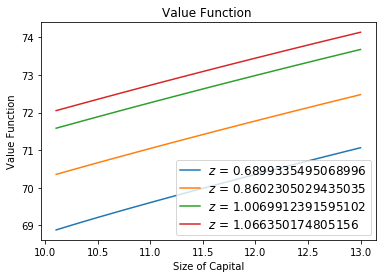

In [12]:
# Plot value function 
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[1:], VF[1:, 0], label='$z$ = ' + str(z_grid[0]))
ax.plot(k_grid[1:], VF[1:, 5], label='$z$ = ' + str(z_grid[5]))
ax.plot(k_grid[1:], VF[1:, 15], label='$z$ = ' + str(z_grid[15]))
ax.plot(k_grid[1:], VF[1:, 19], label='$z$ = ' + str(z_grid[19]))
# Now add the legend with some customizations.
legend = ax.legend(loc='lower right', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital')
plt.ylabel('Value Function')
plt.title('Value Function ')
plt.show()

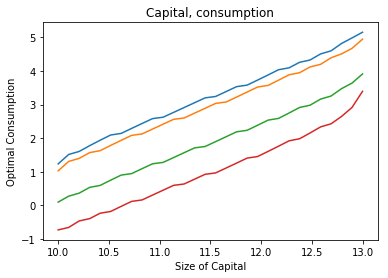

In [13]:
#Plot optimal consumption rule
optK = k_grid[PF]
optC = z_grid * k_grid ** (alpha) + (1 - delta) * k_grid - optK
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[:], optC[:][2], label='Consumption' + str(z_grid[2]))
ax.plot(k_grid[:], optC[:][5], label='Consumption' + str(z_grid[5]))
ax.plot(k_grid[:], optC[:][17], label='Consumption' + str(z_grid[17]))
ax.plot(k_grid[:], optC[:][27], label='Consumption' + str(z_grid[27]))

# Now add the legend with some customizations.
#legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital')
plt.ylabel('Optimal Consumption')
plt.title('Capital, consumption')
plt.show()

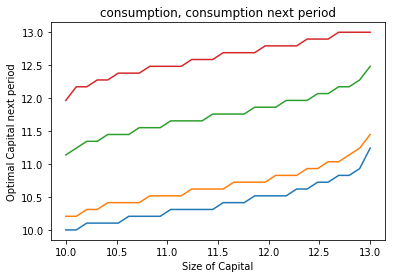

In [14]:
#Plot optimal capital next period
optK = k_grid[PF]
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[:], optK[:][2], label='Consumption' + str(z_grid[2]))
ax.plot(k_grid[:], optK[:][5], label='Consumption' + str(z_grid[5]))
ax.plot(k_grid[:], optK[:][17], label='Consumption' + str(z_grid[17]))
ax.plot(k_grid[:], optK[:][27], label='Consumption' + str(z_grid[27]))
# Now add the legend with some customizations.
#legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital')
plt.ylabel('Optimal Capital next period')
plt.title('consumption, consumption next period')
plt.show()

## Problem 4:

### 1. Bellman Equation:

$$V(w) = Max\{V^U(w), V^J(w)\}$$ 
where:
$$V^U(w)= b + \beta E V(w')$$
and 
$$V^J(w) = E_0 \sum_{t=0}^{\infty} \beta^t w = \frac{w}{1 - \beta} $$

### 2. Solve the model

In [18]:
# Declare parameters
# Preference parameters
beta = 0.96
b = np.linspace(.05, 1, .05)
size_b = len(b)
# Taste shock parameters: AR(1) process: 
mu = 0
sigma = .15
size_w = 10
rho = 0
'''
------------------------------------------------------------------------
Create Grid for State Space    
------------------------------------------------------------------------
w_grid    = vector, size_w 
------------------------------------------------------------------------
'''
'''
Create grid of taste shocks
'''
import ar1_approx as ar1
ln_w_grid, pi_t = ar1.addacooper(size_w, mu, rho, sigma)
w_grid = np.exp(ln_w_grid)
pi = np.transpose(pi_t)
U = w_grid / (1 - beta)

'''
------------------------------------------------------------------------
Value Function Iteration    
------------------------------------------------------------------------
VFtol       = scalar, tolerance required for value function to converge
VFdist      = scalar, distance between last two value functions
VFmaxiter   = integer, maximum number of iterations for value function
V           = matrix, the value functions at each iteration
TV          = matrix, the value function after applying the Bellman operator
PF_discrete = matrix, matrix of policy function: eat=1, not eat=0 
Vstore      = array, stores V at each iteration 
VFiter      = integer, current iteration number
EV          = scalar, expected value function for a given state
U_employed  = matrix, utility from eating cake now
V_unemployed= matrix, value of waiting to eat the cake
VF          = vector, the "true" value function
------------------------------------------------------------------------
'''
#for l in range(size_b):
#Set grid of b
grid_b = np.linspace(0.05, 1, 20)
threshold_vec = np.zeros(20)

#Begin for loop
for q in range(20):

    VFtol = 1e-8 
    VFdist = 7.0 
    VFmaxiter = 500 
    V = np.zeros(size_w) # initial guess at value function
    TV = np.zeros(size_w)
    PF_discrete = np.zeros(size_w)
    Vstore = np.zeros((size_w, VFmaxiter)) #initialize Vstore array
    VFiter = 1 
    while VFdist > VFtol and VFiter < VFmaxiter:
        print('This is the distance', VFdist, VFiter)
        for i in range(size_w): # loop over w
            EV = 0
            for ii in range(size_w):  # loop over w
                EV += pi[i, ii] * V[ii]   # note can move one space because of how we constructed grid
            U_employed = U[i]
            V_unemployed = grid_b[q] + beta * EV 
            TV[i] = max(U_employed, V_unemployed)
            PF_discrete[i] = U_employed >= V_unemployed  # = 1 if take job
            
        Vstore[:, VFiter] = TV # store value function at each iteration for graphing later 
        VFdist = (np.absolute(V - TV)).max()  # check distance
        V = TV
        VFiter += 1 

    if VFiter < VFmaxiter:
        print('Value function converged after this many iterations:', VFiter)
    else:
        print('Value function did not converge')            


    VF = V # solution to the functional equation
    threshold_vec[q]=w_grid[np.argmax(PF_discrete)]

/Users/cacheellsworth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


This is the distance 7.0 1
This is the distance 32.528717766894246 2
Value function converged after this many iterations: 3
This is the distance 7.0 1
This is the distance 32.528717766894246 2
Value function converged after this many iterations: 3
This is the distance 7.0 1
This is the distance 32.528717766894246 2
Value function converged after this many iterations: 3
This is the distance 7.0 1
This is the distance 32.528717766894246 2
Value function converged after this many iterations: 3
This is the distance 7.0 1
This is the distance 32.528717766894246 2
Value function converged after this many iterations: 3
This is the distance 7.0 1
This is the distance 32.528717766894246 2
Value function converged after this many iterations: 3
This is the distance 7.0 1
This is the distance 32.528717766894246 2
Value function converged after this many iterations: 3
This is the distance 7.0 1
This is the distance 32.528717766894246 2
Value function converged after this many iterations: 3
This is 

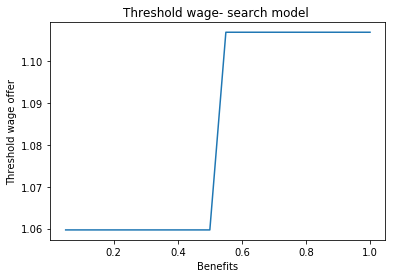

In [23]:
# Plot value function 
plt.figure()
fig, ax = plt.subplots()
ax.plot(grid_b[:], threshold_vec[:])
# Now add the legend with some customizations.
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Benefits')
plt.ylabel('Threshold wage offer')
plt.title('Threshold wage- search model ')
plt.show()

In [25]:
print(threshold_vec)

[1.05968837 1.05968837 1.05968837 1.05968837 1.05968837 1.05968837
 1.05968837 1.05968837 1.05968837 1.05968837 1.10693622 1.10693622
 1.10693622 1.10693622 1.10693622 1.10693622 1.10693622 1.10693622
 1.10693622 1.10693622]
